In [1]:
from shutil import copyfile

import torch
from torch import nn
from torch import optim
import torch.nn.functional as F

from torch.utils.data import random_split, DataLoader

from torchvision import transforms, datasets

import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping, ModelCheckpoint
from pytorch_lightning.metrics import Accuracy

print (torch.cuda.device_count())
print (torch.__version__)

1
1.7.0.dev20200716


### Using pre-trained model

Today we're going to build and fine-tune CNN based on weights pre-trained on ImageNet - one of the most popular classification datasets.
More about imagenet: http://image-net.org/
Setup: classify from a set of 1000 classes.

In [2]:
import requests

# class labels
LABELS_URL = 'https://s3.amazonaws.com/outcome-blog/imagenet/labels.json'
labels = {int(key):value for (key, value) in requests.get(LABELS_URL).json().items()}

In [3]:
print(list(labels.items())[:5])

[(0, 'tench, Tinca tinca'), (1, 'goldfish, Carassius auratus'), (2, 'great white shark, white shark, man-eater, man-eating shark, Carcharodon carcharias'), (3, 'tiger shark, Galeocerdo cuvieri'), (4, 'hammerhead, hammerhead shark')]


In [4]:
print(list(filter(lambda x: 'banana' in x[1], labels.items())))

[(954, 'banana')]


### TorchVision
PyTorch has several companion libraries, one of them being [torchvision](https://github.com/pytorch/vision/tree/master/) - it contains a number of popular vision datasets, preprocessing tools and most importantly, [pre-trained models](https://github.com/pytorch/vision/tree/master/torchvision/models).

For now, we're going to use torch Inception-v3 module.

We're gonna use the inception-v3 network:
![img](https://hackathonprojects.files.wordpress.com/2016/09/googlenet_diagram.png?w=650&h=192)

Let's first look at the code here: [url](https://github.com/pytorch/vision/blob/master/torchvision/models/inception.py)

In [5]:
from torchvision.models.inception import inception_v3

model = inception_v3(pretrained=True,      # load existing weights
                     transform_input=True, # preprocess input image the same way as in training
                    )

model.aux_logits = False # don't predict intermediate logits (yellow layers at the bottom)
model = model.train(False)

In [6]:
import torch

device = torch.device('cuda')
dummy_x = torch.randn(5, 3, 299, 299)
model(dummy_x)

tensor([[-0.8682,  1.0661,  1.6792,  ..., -2.1271, -0.4044,  1.6288],
        [-1.0157,  0.9724,  1.7072,  ..., -2.0927, -0.5111,  1.4796],
        [-0.9138,  0.9584,  2.0340,  ..., -2.3363, -0.3183,  1.5222],
        [-1.1732,  0.9968,  1.8902,  ..., -2.1563, -0.4653,  1.8152],
        [-0.9433,  1.2211,  1.7060,  ..., -2.3141, -0.4420,  1.6585]],
       grad_fn=<AddmmBackward>)

### Predict class probabilities

In [7]:
# If using Colab
!mkdir sample_images
!wget https://raw.githubusercontent.com/yandexdataschool/Practical_DL/sem4_spring19/week04_finetuning/sample_images/albatross.jpg -O sample_images/albatross.jpg

mkdir: cannot create directory ‘sample_images’: File exists
--2020-07-18 12:16:54--  https://raw.githubusercontent.com/yandexdataschool/Practical_DL/sem4_spring19/week04_finetuning/sample_images/albatross.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 199.232.16.133
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|199.232.16.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 11607 (11K) [image/jpeg]
Saving to: ‘sample_images/albatross.jpg’

sample_images/albat 100%[===================>]  11.33K  --.-KB/s    in 0.007s  

2020-07-18 12:16:54 (1.57 MB/s) - ‘sample_images/albatross.jpg’ saved [11607/11607]



In [8]:
! pip install scikit-image

In [9]:
import matplotlib.pyplot as plt
from skimage.transform import resize
%matplotlib inline

def transform_input(img):
    return torch.as_tensor(img.reshape([1, 299, 299, 3]).transpose([0, 3, 1, 2]), dtype=torch.float32)


def predict(img):
    img = transform_input(img)
    
    probs = nn.functional.softmax(model(img), dim=-1)
    
    probs = probs.data.numpy()
    
    top_ix = probs.ravel().argsort()[-1:-10:-1]
    print ('top-10 classes are: \n [prob : class label]')
    for l in top_ix:
        print ('%.4f :\t%s' % (probs.ravel()[l], labels[l].split(',')[0]))
        

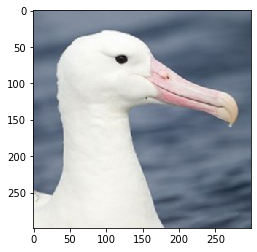

top-10 classes are: 
 [prob : class label]
0.9745 :	albatross
0.0030 :	turnstile
0.0005 :	Shetland sheepdog
0.0005 :	llama
0.0003 :	collie
0.0003 :	drake
0.0003 :	hammerhead
0.0003 :	nipple
0.0003 :	Polaroid camera


In [10]:
img = resize(plt.imread('sample_images/albatross.jpg'), (299, 299))
plt.imshow(img)
plt.show()
predict(img)

### Having fun with pre-trained nets

In [11]:
!wget http://cdn.com.do/wp-content/uploads/2017/02/Donal-Trum-Derogar.jpeg -O img.jpg

--2020-07-18 12:16:56--  http://cdn.com.do/wp-content/uploads/2017/02/Donal-Trum-Derogar.jpeg
Resolving cdn.com.do (cdn.com.do)... 172.67.69.200, 104.26.4.67, 104.26.5.67, ...
Connecting to cdn.com.do (cdn.com.do)|172.67.69.200|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://cdn.com.do/wp-content/uploads/2017/02/Donal-Trum-Derogar.jpeg [following]
--2020-07-18 12:16:56--  https://cdn.com.do/wp-content/uploads/2017/02/Donal-Trum-Derogar.jpeg
Connecting to cdn.com.do (cdn.com.do)|172.67.69.200|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 51048 (50K) [image/jpeg]
Saving to: ‘img.jpg’

img.jpg             100%[===================>]  49.85K  --.-KB/s    in 0.02s   

2020-07-18 12:16:57 (2.77 MB/s) - ‘img.jpg’ saved [51048/51048]



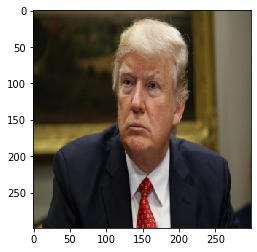

top-10 classes are: 
 [prob : class label]
0.6924 :	suit
0.0912 :	Windsor tie
0.0627 :	groom
0.0045 :	oboe
0.0040 :	academic gown
0.0034 :	Loafer
0.0032 :	wig
0.0028 :	Afghan hound
0.0027 :	bow tie


In [12]:
img = resize(plt.imread('img.jpg'), (299, 299))
plt.imshow(img)
plt.show()

predict(img)

Let's introduce a bit of march'20 reality into our seminar!

In [13]:
!mkdir sample_images
!wget https://raw.githubusercontent.com/yandexdataschool/Practical_DL/spring20/seminar04-finetuning/sample_images/plague-doctor-mask.jpg -O sample_images/mask.jpg

mkdir: cannot create directory ‘sample_images’: File exists
--2020-07-18 12:16:57--  https://raw.githubusercontent.com/yandexdataschool/Practical_DL/spring20/seminar04-finetuning/sample_images/plague-doctor-mask.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 199.232.16.133
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|199.232.16.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 59207 (58K) [image/jpeg]
Saving to: ‘sample_images/mask.jpg’

sample_images/mask. 100%[===================>]  57.82K  --.-KB/s    in 0.04s   

2020-07-18 12:16:58 (1.49 MB/s) - ‘sample_images/mask.jpg’ saved [59207/59207]



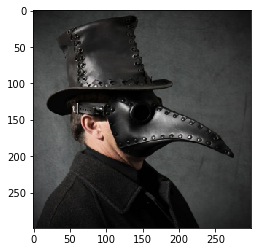

top-10 classes are: 
 [prob : class label]
0.8768 :	cowboy hat
0.0642 :	holster
0.0098 :	sombrero
0.0030 :	breastplate
0.0029 :	cowboy boot
0.0019 :	clog
0.0016 :	revolver
0.0010 :	trench coat
0.0010 :	buckle


In [14]:
img = resize(plt.imread('sample_images/mask.jpg'), (299, 299))
plt.imshow(img)
plt.show()

predict(img)

# Grand-quest: Dogs Vs Cats
* original competition
* https://www.kaggle.com/c/dogs-vs-cats
* 25k JPEG images of various size, 2 classes (guess what)

### Your main objective
* In this seminar your goal is to fine-tune a pre-trained model to distinguish between the two rivaling animals
* The first step is to just reuse some network layer as features

In [ ]:
!wget -nc https://www.dropbox.com/s/ae1lq6dsfanse76/dogs_vs_cats.train.zip?dl=1 -O data.zip
!unzip -n data.zip

### How to get features
During good old days in Torch7 you could access any intermediate output from the sequential model. Nowadays it's a bit more difficult though it's not Tensorflow where you need to compile another model for that. Here we're going to redefine the last layer... yes, to do nothing.

In [15]:
from copy import deepcopy  # in case you still need original model

embedding = deepcopy(model)

# redefine the last layer to be Identity - yeah we won't invent warm water here
embedding.fc = nn.Identity()

assert embedding(transform_input(img)).data.numpy().shape == (1, 2048), "your output for single image should have shape (1, 2048)"
embedding = embedding.to(device)

# for starters
* Train sklearn model, evaluate validation accuracy (should be >80%)

In [15]:
!pip install imageio psutil

In [17]:
#extract features from images
from tqdm import tqdm
from imageio import imread
import PIL.Image as Image
import os
import numpy as np
import psutil
import gc

X = []
Y = []

batch_size = 64
imgs = np.zeros([batch_size, 299, 299, 3])
batch_index = 0

for fname in tqdm(os.listdir('train')):
    
    y = fname.startswith("cat")
    Y.append(y)
    
    img = imread(os.path.join("train", fname))
    
    img = np.array(Image.fromarray(img).resize((299, 299))) / 255.
    imgs[batch_index] = img
    
    if batch_index == batch_size - 1:
        input_tensor = torch.as_tensor(imgs.transpose([0,3,1,2]), dtype=torch.float32, device=device)
    
        # use your embedding model to produce feature vector
        with torch.no_grad():
            features = embedding(input_tensor)
            X.append(features.to('cpu').numpy())
        
        batch_index = 0
        continue
        
    batch_index += 1

100%|██████████| 25000/25000 [02:32<00:00, 163.71it/s]


In [18]:
X = np.concatenate(X) #stack all [1xfeatures] matrices into one. 
assert X.ndim == 2
#WARNING! the concatenate works for [1xN] matrices. If you have other format, stack them yourself.

#crop if we ended prematurely
Y = np.array(Y[:len(X)])

print(X.shape, Y.shape)

(24960, 2048) (24960,)


__load our dakka__
![img](https://s-media-cache-ak0.pinimg.com/564x/80/a1/81/80a1817a928744a934a7d32e7c03b242.jpg)

In [18]:
from sklearn.ensemble import RandomForestClassifier,ExtraTreesClassifier,GradientBoostingClassifier,AdaBoostClassifier
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score

In [19]:
rf = RandomForestClassifier(min_samples_leaf=2, n_jobs=-1, random_state=42)
cross_val_score(rf, X, Y, verbose=10, scoring='accuracy')

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  ................................................................
[CV] .................................... , score=0.981, total=   9.5s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    9.5s remaining:    0.0s


[CV] .................................... , score=0.982, total=   8.6s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   18.1s remaining:    0.0s


[CV] .................................... , score=0.987, total=   8.4s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   26.6s remaining:    0.0s


[CV] .................................... , score=0.983, total=   8.9s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   35.5s remaining:    0.0s


[CV] .................................... , score=0.984, total=   8.7s


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   44.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   44.2s finished


array([0.98116987, 0.98237179, 0.98657853, 0.9833734 , 0.98417468])

**WHAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAT** 
A fucking random forrest gave us >98% accuracy, fucking sick bro. How can neural networks compete???

## Main quest

* Get the score improved!
* You have to reach __at least 95%__ on the test set. More = better.

No methods are illegal: ensembling, data augmentation, NN hacks. 
Just don't let test data slip into training.


### Split the raw image data
  * please do train/validation/test instead of just train/test
  * reasonable but not optimal split is 20k/2.5k/2.5k or 15k/5k/5k

### Build a few layers on top of chosen "neck" layers.
  * a good idea is to just stack more layers inside the same network
  * alternative: stack on top of get_output

### Train the newly added layers for some iterations
  * you can selectively train some weights by sending the correct parameters in the optimizer
      * `opt = torch.optim.Adam([head_only.parameters()])``
  * it's cruicial to monitor the network performance at this and following steps

### Fine-tune the network body
  * probably a good idea to SAVE your new network weights now 'cuz it's easy to mess things up.
  * Moreover, saving weights periodically is a no-nonsense idea
  * even more cruicial to monitor validation performance
  * main network body may need a separate, much lower learning rate

In [19]:
# Save the weights of the original model
torch.save(embedding.state_dict(), 'embedding.pt')

In [48]:
# Aaaand resurrect it from the file
embedding.load_state_dict(torch.load('embedding.pt'))

<All keys matched successfully>

In [49]:
# Create the file structure needed to easily load the pics
if not os.path.isdir('images'):
    os.mkdir('images')

    for fname in os.listdir('train'):
        folder = fname[:3] # dog or cat
        img_name = fname[4:]

        if not os.path.isdir('images/' + folder):
            os.mkdir('images/' + folder)

        copyfile('train/' + fname, 'images/' + folder + '/' + img_name)

In [50]:
# Custom Dataset subclass for transformations
class MapDataset(torch.utils.data.Dataset):
    def __init__(self, dataset, map_fn):
        self.dataset = dataset
        self.map = map_fn

    def __getitem__(self, index):
        return self.map(self.dataset[index][0]), self.dataset[index][1]

    def __len__(self):
        return len(self.dataset)
    
# Transforms
transforms_all = transforms.Compose(
    [
        transforms.Resize((299,299)),
        transforms.ToTensor(),
    ]
)

# Load data, split into train/val/test
full_set = datasets.ImageFolder(root="images")
train_set, val_set, test_set = random_split(full_set, [20000, 2500, 2500])

train_set = MapDataset(train_set, transforms_all)
val_set = MapDataset(val_set, transforms_all)
test_set = MapDataset(test_set, transforms_all)

In [55]:
class FineTuneModel(pl.LightningModule):
    
    def __init__(self, embedding, hidden_size_1=256, dropout=0.5):
        super(FineTuneModel, self).__init__()
               
        self.metric = Accuracy(num_classes=2)
        
        self.base_model = embedding
        
        # Let's make it trainableeeeeeeeee
        self.base_model.requires_grad_(True)

        self.head = nn.Sequential(
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(2048, hidden_size_1),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_size_1, 2)
        )
        
    def forward(self, input):
        out = self.base_model(input)
        out = self.head(out)
        return out
        
    def configure_optimizers(self):
        optimizers = [optim.Adam([{'params': self.head.parameters(), 'lr': 1e-3},
                                {'params': self.base_model.parameters(), 'lr': 1e-4}],
                                 weight_decay=1e-4)]
        schedulers = [{
            'scheduler': optim.lr_scheduler.ReduceLROnPlateau(optimizers[0], patience=10),
            'reduce_on_plateau': True
        }]

        return optimizers, schedulers
    
    def training_step(self, batch, batch_idx):
        x, y = batch
        loss = F.cross_entropy(self(x), y)

        logs = {"train_loss": loss}
        return {"loss": loss, "log": logs}

    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = F.cross_entropy(logits, y)
        labels_hat = torch.argmax(logits, dim=1)

        accuracy = self.metric(y, labels_hat)

        return {"val_loss": loss, "val_acc": accuracy}

    def validation_epoch_end(self, outputs):
        avg_loss = torch.stack([x["val_loss"] for x in outputs]).mean()
        avg_acc = torch.stack([x["val_acc"] for x in outputs]).mean()

        logs = {"val_loss": avg_loss, "val_acc": avg_acc}
        return {"val_loss": avg_loss, "log": logs}

    def test_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = F.cross_entropy(logits, y)
        labels_hat = torch.argmax(logits, dim=1)

        accuracy = self.metric(y, labels_hat)

        return {"test_loss": loss, "test_acc": accuracy}

    def test_epoch_end(self, outputs):
        avg_loss = torch.stack([x["test_loss"] for x in outputs]).mean()
        test_acc = torch.stack([x["test_acc"] for x in outputs]).mean()

        logs = {"test_loss": avg_loss, "test_acc": test_acc}
        return {"test_acc": test_acc, "log": logs}

In [56]:
# Prepare the trainer and callbacks/logging
logger = pl.loggers.TensorBoardLogger('tb_logs', name='fine_tuned_model')
early_stop_callback = EarlyStopping(
    monitor="val_loss", min_delta=1e-3, patience=3, mode="min"
)
checkpoint_callback = ModelCheckpoint(
    filepath='checkpoints', monitor="val_loss", mode="min"
)

trainer = pl.Trainer(
    gpus=1,
    precision=16,
    logger=logger,
    early_stop_callback=early_stop_callback,
    checkpoint_callback=checkpoint_callback,
    max_epochs= 200,
    weights_summary=None,
    log_gpu_memory="all",
)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
CUDA_VISIBLE_DEVICES: [0]
Using native 16bit precision.


In [57]:
# Prepare the dataloaders
batch_size = 64
train_loader = DataLoader(
    train_set, batch_size=batch_size, shuffle=True, num_workers=8, pin_memory=True
)
val_loader = DataLoader(
    val_set, batch_size=batch_size, num_workers=8, pin_memory=True
)
test_loader = DataLoader(
    test_set, batch_size=batch_size, num_workers=8, pin_memory=True
)

In [58]:
ft_model = FineTuneModel(embedding, dropout=0.5)

# Train
trainer.fit(ft_model, train_loader, val_loader)

# Test
trainer.test(ft_model, test_dataloaders=test_loader)

--------------------------------------------------------------------------------
TEST RESULTS
{'test_acc': tensor(0.9898), 'test_loss': tensor(0.0345, device='cuda:0')}
--------------------------------------------------------------------------------



{'test_acc': 0.9898437261581421, 'test_loss': 0.03454284369945526}

**Summary:**
Wow, crazy - we got 99% accuracy. How so? Well, stacking layers on top of the original model really didn't do shit - I was getting at most like 98%. No wonder RF did better, it was able to capture much more complicated relatinships.

What really did the trick was to train the weights of the original model as well (at a much lower learning rate). This pushed the accuracy to the really unbelievable 99%.

# Bonus: #deepdream

https://twitter.com/search?q=%23deepdream&src=typd

Code is heavily based on https://github.com/thesemicolonguy/deep-dream-pytorch

Original blogpost where more ideas can be taken from: https://research.googleblog.com/2015/06/inceptionism-going-deeper-into-neural.html

In [ ]:
from PIL import Image, ImageFilter, ImageChops
from torchvision import transforms
import numpy as np

In [ ]:
modulelist = list(model.children())
print(len(modulelist))

In [ ]:
preprocess = transforms.Compose([
#    transforms.Resize((299, 299)),  # do we really need this now?
    transforms.ToTensor()#,
    ])


def dd_helper(image, layer, iterations, lr):
    input_var = torch.tensor(preprocess(image).unsqueeze(0), requires_grad=True, device='cuda:0', 
                             dtype=torch.float32)
    model.zero_grad()
    for i in range(iterations):
        out = input_var
        for j in range(layer):
            out = modulelist[j](out)
        loss = out.norm()
        loss.backward()
        input_var.data = input_var.data + lr * input_var.grad.data
    
    input_im = input_var.data.squeeze(0).cpu()
    input_im.transpose_(0, 1)
    input_im.transpose_(1, 2)
    input_im = np.clip(input_im, 0, 1)
    im = Image.fromarray(np.uint8(input_im * 255))
    return im

In [ ]:
def deep_dream(image, layer, iterations, lr, octave_scale, num_octaves):
    if num_octaves>0:
        image1 = image.filter(ImageFilter.GaussianBlur(2))
        if (image1.size[0] / octave_scale < 1 or image1.size[1] / octave_scale < 1):
            size = image1.size
        else:
            size = (int(image1.size[0] / octave_scale), int(image1.size[1] / octave_scale))
            
        image1 = image1.resize(size, Image.ANTIALIAS)
        image1 = deep_dream(image1, layer, iterations, lr, octave_scale, num_octaves-1)
        size = (image.size[0], image.size[1])
        image1 = image1.resize(size, Image.ANTIALIAS)
        image = ImageChops.blend(image, image1, 0.6)
    print("-------------- Recursive level: ", num_octaves, '--------------')
    img_result = dd_helper(image, layer, iterations, lr)
    img_result = img_result.resize(image.size)
    plt.imshow(img_result)
    return img_result

In [ ]:
img = Image.fromarray(plt.imread('img.jpg'))
img

In [ ]:
output = deep_dream(img, 5, 5, 0.3, 2, 20)

In [ ]:
output = deep_dream(img, 12, 5, 0.2, 2, 1)

In [ ]:
#can you implement one class probability optimization to make model dream about bananas
<YOUR CODE>

# Bonus 2: Adversarial Attack

Original PyTorch tutorial is [here](https://pytorch.org/tutorials/beginner/fgsm_tutorial.html)

In [ ]:
# Change the Deep Dream step function
# to make it doing adversarial example from original image

def dd_helper_modified(image, layer, iterations, lr):
    input_var = torch.tensor(preprocess(image).unsqueeze(0), requires_grad=True, device='cuda:0',
                             dtype=torch.float32)
    model.zero_grad()
    for i in range(iterations):
        out = input_var
        for j in range(layer):  # maybe change this
            out = modulelist[j](out)
        loss = out.norm()
        loss.backward()
        input_var.data = input_var.data + lr * input_var.grad.data # and probably this
    input_im = input_var.data.squeeze(0).cpu()
    input_im.transpose_(0, 1)
    input_im.transpose_(1, 2)
    input_im = np.clip(input_im, 0, 1)
    im = Image.fromarray(np.uint8(input_im * 255))
    return im

In [ ]:
img = Image.fromarray(plt.imread('img.jpg'))
img_adv = dd_helper(img, ?, ?, ?)   # YOUR CODE
img_adv

In [ ]:
predict(resize(np.asarray(img_adv), (299, 299)))